# Feature Engineering 2
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/feature_engineering_2.ipynb)

In [1]:
random_state = 42

In [2]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets



IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    sys.path.insert(0,"/content/structural_health_monitoring/src")
    sys.path.insert(0,"/content/structural_health_monitoring/data")    
else:
    sys.path.insert(0,"../src")
    sys.path.insert(0,"../data")
    


try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

In [3]:
from DataDownloader import DataDownloader as ddl
from data_utils import load_processed_data, FEATURE_LIST
from manifold_utils import tsne_embedding
from LogFilterbank import LogFilterbank
from plot_utils import plot_embedding_targets, init_plotting
from plot_utils import plot_classwise_dist, plot_classwise_kde
from feature_utils import extract_dctc

# configure fonts, etc...
init_plotting()

In [4]:
url = r"https://sandbox.zenodo.org/record/1115172/files/data_synthetic.zip"
DATA_PATH = Path(r"../data/synthetic/")


start_time = time.perf_counter()
dl_succeed = ddl.download_and_unpack(url, DATA_PATH, cache=True)
end_time = time.perf_counter()
print(f"time passed: {end_time-start_time:.2f} s")
print(f"downloading successful: {dl_succeed}")

time passed: 5.24 s
downloading successful: True


## Filterbank Configuration

In [5]:
# configuration
sr = 120000 #originally from df['kHz'].iloc[-1]*1000*2 # from measurement, highest f[kHz]*2
n_log_bins = 87
n_fft = 1600
n_fft_bins = 801
f_min = 1300
norm = 'height'

fb = LogFilterbank(sr=sr, n_fft_bins=n_fft_bins, n_log_bins=n_log_bins, f_min=f_min, norm=norm)

## Loading Data

In [6]:
to_dB = True

PATH = r"..\data\synthetic"

DATA_PATH = Path(r"../data/synthetic/")

from pathlib import Path
file_names = list(DATA_PATH.glob('**/*.csv'))

# cache file for faster data loading on later iterations
pickle_name = Path(DATA_PATH, f"filtered_specs__fmin_{fb.f_min}__fmax_{fb.f_max}__lbins_{fb.n_log_bins}.pkl")
pickle_name

WindowsPath('../data/synthetic/filtered_specs__fmin_1300__fmax_60000.0__lbins_87.pkl')

In [7]:
%%time
df = load_processed_data(file_names, fb, y_col=[FEATURE_LIST[0], FEATURE_LIST[1]], to_dB=to_dB, cache_file=pickle_name)

CPU times: total: 297 ms
Wall time: 272 ms


In [8]:
target_col = 'y_radius'

df = df.sort_values(by=target_col) # make sure the class labels are sorted for further convenience

## DCT for dimensionality reduction

In [9]:
X = df[df.columns[0:fb.n_log_bins]].values

n_coeffs = 32
X_dct = extract_dctc(X=X, n_coeffs=n_coeffs)

## Scaling

In [10]:
scaler = StandardScaler()
scaler.fit(X_dct)

X_dct = scaler.transform(X_dct)

In [11]:
plot_df = pd.DataFrame(X_dct)
plot_df[target_col] = df[target_col]

plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0         34152 non-null  float32
 1   1         34152 non-null  float32
 2   2         34152 non-null  float32
 3   3         34152 non-null  float32
 4   4         34152 non-null  float32
 5   5         34152 non-null  float32
 6   6         34152 non-null  float32
 7   7         34152 non-null  float32
 8   8         34152 non-null  float32
 9   9         34152 non-null  float32
 10  10        34152 non-null  float32
 11  11        34152 non-null  float32
 12  12        34152 non-null  float32
 13  13        34152 non-null  float32
 14  14        34152 non-null  float32
 15  15        34152 non-null  float32
 16  16        34152 non-null  float32
 17  17        34152 non-null  float32
 18  18        34152 non-null  float32
 19  19        34152 non-null  float32
 20  20        34152 non-null  fl

## Classwise Feature Distribution

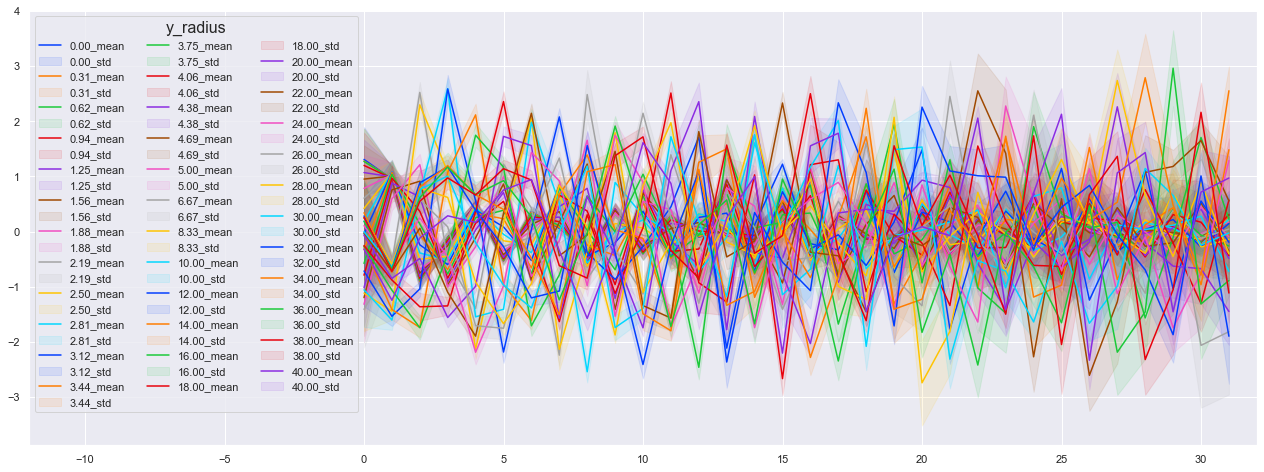

In [12]:
fig = plot_classwise_dist(df=plot_df)

fig.gca().legend(ncol=3, loc='best', title=target_col)
fig.get_axes()[0].set(xlim=(-12, len(plot_df.columns)-1));

## Classwise Individual Feature Distribution

In [13]:
cntr = Counter(plot_df[target_col])
labels = list(cntr.keys())
palette = sns.color_palette("bright", len(cntr.keys()))

In [14]:
feature_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(plot_df.columns)-2,
    step=1,
    description='feature:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='100%')
)


focus_slider = widgets.IntSlider(
    value=-1,
    min=-1,
    max=len(cntr.keys())-1,
    step=1,
    description='target focus:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='100%')
)


def plot_feature_kde(df, label_col, labels, palette=None, feature_idx=0, focus=-1):
    fig = plot_classwise_kde(df=df, label_col=label_col, labels=labels,
                             palette=palette, feature_idx=feature_idx,
                             focus=focus)
    fig.gca().legend(ncol=2, loc='best', title=label_col)
    
    
widgets.interact(plot_feature_kde,
                 df=widgets.fixed(plot_df),
                 label_col=widgets.fixed(target_col),
                 labels=widgets.fixed(labels),
                 palette=widgets.fixed(palette),
                 feature_idx=feature_slider,
                 focus=focus_slider);

interactive(children=(IntSlider(value=0, continuous_update=False, description='feature:', layout=Layout(width=…

## Explore T-SNE embedding

In [15]:
X_embedded = tsne_embedding(X=X_dct, perplexity=50)

X_embedded.shape

(34152, 2)

In [16]:
df_embedded = pd.DataFrame(X_embedded, columns=['x', 'y'])
df_embedded[target_col] = np.copy(df[target_col].values)

df_embedded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         34152 non-null  float32
 1   y         34152 non-null  float32
 2   y_radius  34152 non-null  float32
dtypes: float32(3)
memory usage: 400.3 KB


In [17]:
# predefine palette to keep it from changing after thresholding changes the number of classes to be mapped, hence ever changing the palette
palette = dict(zip(cntr.keys(), sns.color_palette(palette="bright", n_colors=len(cntr.keys()))))
palette.update({-1: "k"})

In [18]:
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')


def embedding_widget(df, label_col, thresh=0., palette=palette):
    y = np.copy(df[label_col].values)
    y[y<thresh] = -1
        
    X = df.drop(columns=[label_col]).values
    
    fig = plot_embedding_targets(X, y, alpha=0.2, palette=palette)
    fig.set_size_inches((14, 14))
    plt.title("2D Embedding")
    legend = plt.legend(ncol=3, loc="upper left", title=label_col)
        
    # format legend entries
    for text in legend.get_texts():
        text.set_text(f"{float(text.get_text()):.2f}")


thresh_slider = widgets.FloatSlider(
    value=0.,
    min=0.0,
    max=40,
    step=0.01,
    description='thresh:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout=widgets.Layout(width='90%')
)

widgets.interact(embedding_widget,
                 df=widgets.fixed(df_embedded),
                 label_col=widgets.fixed(target_col),
                 thresh=thresh_slider,
                 palette=widgets.fixed(palette));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='thresh:', layout=Layout(wid…